In [81]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import os
from sklearn.linear_model import LinearRegression
from scipy import stats

Подключаем необходимые библиотеки.


In [71]:
os.chdir(r"C:\Users\ммм\Desktop\CSC\Анализ данных\ДЗ\ДЗ №5")

Задаем рабочую папку.

In [94]:
data=pd.read_csv('Chicago_hotels.csv', sep=';')
data

,date1,date2,x1,x2,x3,x4
0,January,1994,"44,3","104,04","51,9","72,15"
1,February,1994,"54,7","102,74","60,1","73,47"
2,March,1994,"61,9","105,23",65,"74,91"
3,April,1994,"69,1","113,63","69,8","79,06"
4,May,1994,"70,8","120,77","72,4","82,07"
...,...,...,...,...,...,...
115,August,2003,,,,
116,September,2003,,,,
117,October,2003,,,,
118,November,2003,,,,


Выполняется первый вариант работы, поэтому исключим из таблицы стобцы х2, х3 и х4 - так как мы не будем их использовать в качестве регрессоров в уравнении регресии, потому что для них, как и для нашего столбца х1, нет значений на прогнозный период.

In [95]:
data = data.drop(columns = ['x2','x3','x4'])
data[:113]

,date1,date2,x1
0,January,1994,"44,3"
1,February,1994,"54,7"
2,March,1994,"61,9"
3,April,1994,"69,1"
4,May,1994,"70,8"
...,...,...,...
108,January,2003,"51,6"
109,February,2003,"52,7"
110,March,2003,65
111,April,2003,69


In [92]:
type(data['x1'][1])

str

Заметим, что импортированные данные из экселя в столбце x1 имеют тип string. Заменим значения в cтобце x1 на тип float.

In [96]:
for i in range(112):
    data.loc[i, 'x1'] = float(data['x1'][i].replace(',', '.'))

In [97]:
df = data.drop(columns=['date1','date2'])
df = df[:112]
df['month_num'] = range(1, len(df) + 1)
df

,x1,month_num
0,44.3,1
1,54.7,2
2,61.9,3
3,69.1,4
4,70.8,5
...,...,...
107,54.8,108
108,51.6,109
109,52.7,110
110,65,111


Будем работать с временным рядом за период с января 1994 по апрель 2003: создадим столбец month_num с номером месяца (убрав изначальные даты).

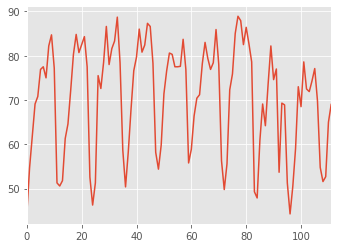

In [98]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['x1'].plot(ax=ax1)

Из графика временного ряда видно, что тренд линейный.

In [100]:
df["m01"] = ([1,0,0,0,0,0,0,0,0,0,0,0]*10)[:112]
df["m02"] = ([0,1,0,0,0,0,0,0,0,0,0,0]*10)[:112]
df["m03"] = ([0,0,1,0,0,0,0,0,0,0,0,0]*10)[:112]
df["m04"] = ([0,0,0,1,0,0,0,0,0,0,0,0]*10)[:112]
df["m05"] = ([0,0,0,0,1,0,0,0,0,0,0,0]*10)[:112]
df["m06"] = ([0,0,0,0,0,1,0,0,0,0,0,0]*10)[:112]
df["m07"] = ([0,0,0,0,0,0,1,0,0,0,0,0]*10)[:112]
df["m08"] = ([0,0,0,0,0,0,0,1,0,0,0,0]*10)[:112]
df["m09"] = ([0,0,0,0,0,0,0,0,1,0,0,0]*10)[:112]
df["m10"] = ([0,0,0,0,0,0,0,0,0,1,0,0]*10)[:112]
df["m11"] = ([0,0,0,0,0,0,0,0,0,0,1,0]*10)[:112]
df["m12"] = ([0,0,0,0,0,0,0,0,0,0,0,1]*10)[:112]

Создаем столбцы, которые будут отвечать за сезонную составляющую временного ряда.

По аналогии с лекцией, создаем стобец откликов и столбец предикторов (взяв в качестве базового месяца январь).

In [103]:
y = df['x1']
x = df.drop(columns=["x1",'m01'])

In [104]:
def regression_coef(model, X, y):
    coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef

Воспользуемся функцией regression_coef из скрипта с лекции и узнаем значения коэффицентов модели и p-value этих коэффициентов.

In [195]:
model = LinearRegression()
model.fit(x, y)
regression_coef(model, x, y)

,predictor,coef,pvalue
0,intercept,51.476517,0.000000e+00
1,month_num,-0.029573,5.531816e-02
2,m02,6.379573,7.255383e-03
3,m03,17.589146,1.365841e-11
4,m04,21.518719,2.220446e-15
5,m05,26.435298,0.000000e+00
6,m06,32.653760,0.000000e+00
7,m07,29.372222,0.000000e+00
8,m08,28.568462,0.000000e+00
9,m09,28.620257,0.000000e+00


Заметим, что p-value коэффициенты перед month_num и m12 не сильно отличается от уровня значимости $\alpha = 0.05$, поэтому гипотезу о равенстве коэффициентов перед month_num и m12 нулю мы не будем принимать и оставим все как есть.

Коэффициент детерминации следующий.

In [196]:
print('R^2: {0}'.format(model.score(x, y)))

R^2: 0.8361731186813547


Сравним значения нашей модели и исходные данные.

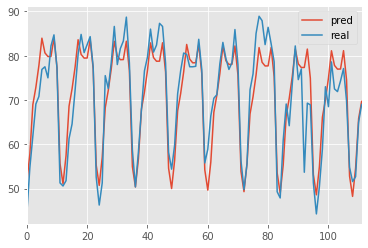

In [197]:
pred = pd.DataFrame({
    'pred': model.predict(x),
    'real': y})
pred.plot()

Составим прогноз на период с мая 2003 по декабрь 2003 на основе полученной модели. 

In [198]:
df2 = pd.DataFrame()
df2['month_num'] = range(112, 120)
df2["m02"] = [0,0,0,0,0,0,0,0]
df2["m03"] = [0,0,0,0,0,0,0,0]
df2["m04"] = [0,0,0,0,0,0,0,0]
df2["m05"] = [1,0,0,0,0,0,0,0]
df2["m06"] = [0,1,0,0,0,0,0,0]
df2["m07"] = [0,0,1,0,0,0,0,0]
df2["m08"] = [0,0,0,1,0,0,0,0]
df2["m09"] = [0,0,0,0,1,0,0,0]
df2["m10"] = [0,0,0,0,0,1,0,0]
df2["m11"] = [0,0,0,0,0,0,1,0]
df2["m12"] = [0,0,0,0,0,0,0,1]

In [199]:
df2

,month_num,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,112,0,0,0,1,0,0,0,0,0,0,0
1,113,0,0,0,0,1,0,0,0,0,0,0
2,114,0,0,0,0,0,1,0,0,0,0,0
3,115,0,0,0,0,0,0,1,0,0,0,0
4,116,0,0,0,0,0,0,0,1,0,0,0
5,117,0,0,0,0,0,0,0,0,1,0,0
6,118,0,0,0,0,0,0,0,0,0,1,0
7,119,0,0,0,0,0,0,0,0,0,0,1


Сами прогнозные значения.

In [200]:
forecast = model.predict(df2)
forecast

array([74.59963477, 80.78852366, 77.47741255, 76.64407922, 76.66630144,
       80.81074588, 74.21074588, 52.51074588])

Проиллюстрируем прогноз на графике.

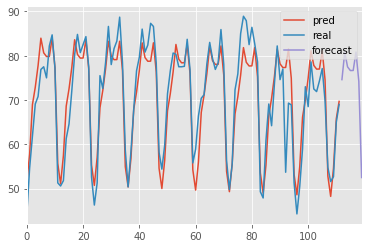

In [201]:
pred = pd.DataFrame({
    'pred': np.hstack((model.predict(x), np.array([np.nan]*8))),
    'real': np.hstack((y, np.array([np.nan]*8))),
    'forecast': np.hstack((np.array([np.nan]*112), forecast))})
pred.plot()

То же самое, только с непрерывной прогнозной кривой.

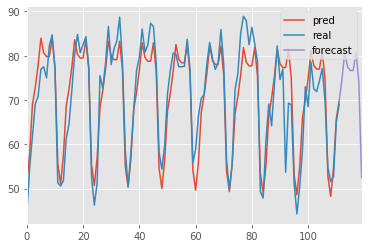

In [202]:
pred = pd.DataFrame({
    'pred': np.hstack((model.predict(x), np.array([np.nan]*8))),
    'real': np.hstack((y, np.array([np.nan]*8))),
    #'forecast': np.hstack((np.array([np.nan]*112), forecast))})
    'forecast': np.hstack((np.array([np.nan]*111 + [model.predict(x)[-1]]), forecast))})
pred.plot()

Внесем прогноз в таблицу с исходными данными.

In [203]:
data['x1'] = list(df['x1']) + list(forecast)
data

,date1,date2,x1
0,January,1994,44.300000
1,February,1994,54.700000
2,March,1994,61.900000
3,April,1994,69.100000
4,May,1994,70.800000
...,...,...,...
115,August,2003,76.644079
116,September,2003,76.666301
117,October,2003,80.810746
118,November,2003,74.210746


In [204]:
data[112:]

,date1,date2,x1
112,May,2003,74.599635
113,June,2003,80.788524
114,July,2003,77.477413
115,August,2003,76.644079
116,September,2003,76.666301
117,October,2003,80.810746
118,November,2003,74.210746
119,December,2003,52.510746


Вывод: в ходе лабораторной работы была составлена модель линейной регресии временного ряда с сезонной составляющей, на основе которой был составлен прогноз коэффициентов загрузки гостиниц в процентах на период с мая 2003 года по декабрь 2003 года (который приведен в таблице и на графике выше).